# Time series analysis of sentiments in period of time

In [40]:
import pandas as pd
import pmdarima
import numpy as np
import statsmodels.tsa.arima_model as stm
import plotly.express as px
import plotly.graph_objs as go
import kaleido
import math
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as stm_plots
%matplotlib inline

## Loading data and features extraction

In [2]:
df_1 = pd.read_csv('tweets_sentiments.csv')
df_2 = pd.read_csv('output.csv')

In [3]:
df_1.head(10)

,Text,Tension
0,bardzo ciekawa według miąć opracować,0
1,jeden z powód dla który wysyłać tak duży pomoc...,-1
2,przekazać jugosłowiański czołg bojowy ten wari...,0
3,przekazać jugosłowiański czołg bojowy ten wari...,0
4,clip,0
5,minuta w parlament europejski,0
6,przekazać jugosłowiański czołg bojowy ten wari...,0
7,przekazać jugosłowiański czołg bojowy ten wari...,0
8,zgodzić siebie na zakup ciężki bronić do bezpł...,0
9,minuta w parlament europejski,0


In [4]:
df_2.head(10)

,Unnamed: 0,id,text,retweet_count,created_at,author,location,is_verified
0,0.0,1517289557741477890,"Bardzo ciekawe, według mnie, opracowanie #Ukra...",0,2022-04-21 23:49:55+00:00,AntoniPiechocki,NaN,False
1,1.0,1517284025928495104,"RT @propeertys: Jednym z powodów, dla których ...",18,2022-04-21 23:27:56+00:00,52_macius,Poznań Stare Miasto / EU,False
2,2.0,1517281903241482241,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:19:30+00:00,KozlowskiMarek,Wrocław,False
3,3.0,1517281417943736321,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:17:34+00:00,lucinda_10,NaN,False
4,4.0,1517280783345635329,.2345z #PeerTube CLIP https://t.co/OnDvp8AxN0 ...,0,2022-04-21 23:15:03+00:00,BastardHegels,NaN,False
5,5.0,1517280086541717504,RT @dabrowska_hf: 7 minut w Parlamencie Europe...,9,2022-04-21 23:12:16+00:00,karolk18,NaN,False
6,6.0,1517279847885774852,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:11:20+00:00,MarioRebeliant,Poland,False
7,7.0,1517279637080100865,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:10:29+00:00,52_macius,Poznań Stare Miasto / EU,False
8,8.0,1517279617647882241,RT @propeertys: UE zgodziła się na zakup ciężk...,44,2022-04-21 23:10:25+00:00,djankowski10,NaN,False
9,9.0,1517279343763984384,RT @dabrowska_hf: 7 minut w Parlamencie Europe...,9,2022-04-21 23:09:19+00:00,RenataJasinskaG,"Płock, Polska",False


In [5]:
# We should take created_at column from df_2 and Tension columns from df_1 and create new data frame which will be time series
ts = pd.DataFrame(data = np.array(df_1['Tension']), index = df_2['created_at'], columns = ['Tension'])
ts = ts.sort_index(ascending = True)
ts.head(10)

,Tension
created_at,
2022-04-15 21:02:01+00:00,-1
2022-04-15 21:02:23+00:00,-1
2022-04-15 21:04:04+00:00,0
2022-04-15 21:04:19+00:00,0
2022-04-15 21:04:21+00:00,-1
2022-04-15 21:05:14+00:00,-1
2022-04-15 21:05:17+00:00,-1
2022-04-15 21:05:58+00:00,0
2022-04-15 21:06:49+00:00,1


In [6]:
# We need to make moving sum

def moving_sum(pd_series):
    """Function returns array-like object with moving sum of pd_series"""
    
    s = 0
    result = []
    
    for element in pd_series:
        s += element
        result.append(s)
        
    return result

ts['moving_tension'] = moving_sum(ts['Tension'])

del ts['Tension']

In [7]:
ts.head(10)

,moving_tension
created_at,
2022-04-15 21:02:01+00:00,-1
2022-04-15 21:02:23+00:00,-2
2022-04-15 21:04:04+00:00,-2
2022-04-15 21:04:19+00:00,-2
2022-04-15 21:04:21+00:00,-3
2022-04-15 21:05:14+00:00,-4
2022-04-15 21:05:17+00:00,-5
2022-04-15 21:05:58+00:00,-5
2022-04-15 21:06:49+00:00,-4


In [23]:
def plot_time_series(time_series, text = 'tension', title = 'Tweets', x_axis = 'Days'):
    """Function plots time series"""
    
    fig = go.Figure(data=go.Scatter(x=time_series.index, 
                            y=time_series.iloc[:, 0],
                            marker_color='indianred', text=text))
    fig.update_layout({"title": title,
                       "xaxis": {"title":x_axis},
                       "yaxis": {"title":"Total {}".format(text)},
                       "showlegend": False})
    fig.show()

In [24]:
plot_time_series(ts)

## Spliting into training and test dataset

In [9]:
train_ind = int(len(ts)*0.8)

ts_train = ts[:train_ind]
ts_test = ts[train_ind:]

In [26]:
plot_time_series(ts_train, text = 'tension', title = 'Tweets - training part of dataset', x_axis = 'Days')

In [27]:
plot_time_series(ts_test, text = 'tension', title = 'Tweets - test part of dataset', x_axis = 'Days')

## Modelling

We can see a deterministic component of trend in our time series, so we should differentiate time series with order equals to one or two to remove that trend.

In [33]:
plot_time_series(ts_train.diff(), title = 'Time series (training part) after one differentation')

One differentation removed deterministic component of trend.

In [37]:
ts_train_diff = ts_train.diff()
ts_train_diff = ts_train_diff.dropna()

No we should plot the ACF and PACF functions (estimators of the ACF and PACF functions) to identify orders $p$ and $q$ in the ARMA($p$, $q$) model.

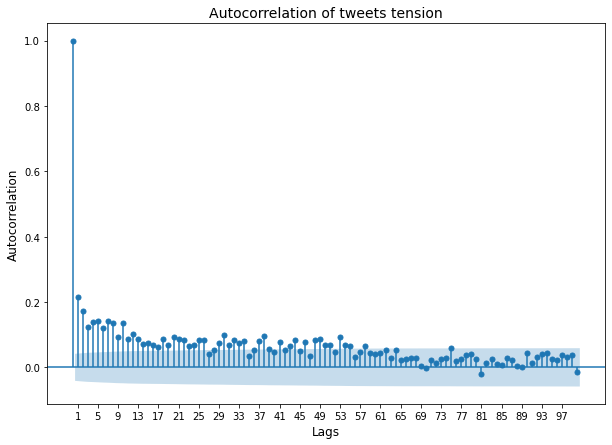

In [52]:
plt.rc("figure", figsize=(10, 7))
stm_plots.plot_acf(ts_train_diff, lags = 100)
plt.xlabel('Lags', fontsize=12)
plt.xticks([_ for _ in range(1, 101, 4)])
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of tweets tension', fontsize=14)
plt.show()

From the plot above we can identify the model ARMA(0, 53) (or ARIMA(0, 1, 53)), because further autocorrelations are not significant (the significance level is equal to 0.05). But it's too complicated model.

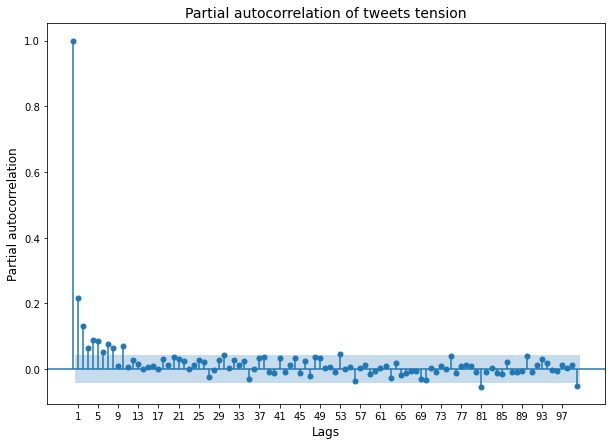

In [53]:
plt.rc("figure", figsize=(10, 7))
stm_plots.plot_pacf(ts_train_diff, lags = 100)
plt.xlabel('Lags', fontsize=12)
plt.xticks([_ for _ in range(1, 101, 4)])
plt.ylabel('Partial autocorrelation', fontsize=12)
plt.title('Partial autocorrelation of tweets tension', fontsize=14)
plt.show()

The plot above suggests to choose the ARMA(10,0) (ARIMA(10,1,0)) model, because further partial autocorrelations are not significant (the significance level is equal to 0.05). Now we use Hyndman-Khandakar algorithm to find the ARMA($p$, $q$) model, where $p$, $q$ are greater than zero in the same time.